In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
## install required packages
!pip install swig
!pip install wrds
!pip install pyportfolioopt
!pip install --upgrade ipykernel
## install finrl library
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.7 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.10
    Uninstalling SQLAlchemy-2.0.10:
      Successfully uninstalled SQLAlchemy-2.0.10
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 6.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.2/152.2 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/usr/local/lib/python3.10/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)
/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [4]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
) # 각 종 parameter들이 정의되어 있다.
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  getpass.getpass = self._save_getpass


In [5]:
# from config.py, TRAIN_START_DATE is a string
print(TRAIN_START_DATE)
# from config.py, TRAIN_END_DATE is a string
print(TRAIN_END_DATE)

2014-01-06
2020-07-31


In [6]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TRADE_START_DATE = '2021-10-01'
TRADE_END_DATE = '2023-05-05'

In [7]:
tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

In [8]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = tickers).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (30213, 8)


In [9]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,33.580002,34.020000,33.450001,25.488930,7567500,XLB,0
1,2010-01-04,57.919998,58.810001,57.790001,38.080170,16928400,XLE,0
2,2010-01-04,11.795288,11.965881,11.770918,9.385941,92942347,XLF,0
3,2010-01-04,28.090000,28.320000,27.959999,21.880188,7471500,XLI,0
4,2010-01-04,23.139999,23.290001,23.100000,19.150229,8449400,XLK,0


In [10]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2010-01-04,33.580002,34.020000,33.450001,25.488930,7567500,XLB,0
1,2010-01-04,57.919998,58.810001,57.790001,38.080170,16928400,XLE,0
2,2010-01-04,11.795288,11.965881,11.770918,9.385941,92942347,XLF,0
3,2010-01-04,28.090000,28.320000,27.959999,21.880188,7471500,XLI,0
4,2010-01-04,23.139999,23.290001,23.100000,19.150229,8449400,XLK,0


In [11]:
INDICATORS

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  getpass.getpass = self._save_getpass


['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [12]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)
# 각 timestep에 지표들을 달아준다.
processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3356, 8)
Successfully added vix
Successfully added turbulence index


In [13]:
processed.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  getpass.getpass = self._save_getpass


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-01-04,33.580002,34.020000,33.450001,25.488930,7567500,XLB,0,0.0,25.646678,25.41359,100.0,66.666667,100.0,25.488930,25.488930,20.040001,0.0
1,2010-01-04,57.919998,58.810001,57.790001,38.080170,16928400,XLE,0,0.0,25.646678,25.41359,100.0,66.666667,100.0,38.080170,38.080170,20.040001,0.0
2,2010-01-04,11.795288,11.965881,11.770918,9.385941,92942347,XLF,0,0.0,25.646678,25.41359,100.0,66.666667,100.0,9.385941,9.385941,20.040001,0.0
3,2010-01-04,28.090000,28.320000,27.959999,21.880188,7471500,XLI,0,0.0,25.646678,25.41359,100.0,66.666667,100.0,21.880188,21.880188,20.040001,0.0
4,2010-01-04,23.139999,23.290001,23.100000,19.150229,8449400,XLK,0,0.0,25.646678,25.41359,100.0,66.666667,100.0,19.150229,19.150229,20.040001,0.0


In [14]:
#prediction 데이터 통합

prediction_dataset = pd.read_csv('/content/drive/MyDrive/kubig_financial/DLinear_prediction.csv')
prediction_dataset.drop('Unnamed: 0', axis=1, inplace=True)

#transform the dataframe to date, tic, close format
prediction_dataset = pd.melt(prediction_dataset, id_vars=['date'], value_vars=tickers)
prediction_dataset = prediction_dataset.rename(columns={'variable': 'tic', 'value': 'prediction'})

#transform the dataframe ordered by date
prediction_dataset = prediction_dataset.sort_values(['date','tic'],ignore_index=True)
prediction_dataset

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  getpass.getpass = self._save_getpass


,date,tic,prediction
0,2010-04-19,XLB,26.115305
1,2010-04-19,XLE,38.589978
2,2010-04-19,XLF,9.725630
3,2010-04-19,XLI,25.475499
4,2010-04-19,XLK,18.537268
...,...,...,...
29542,2023-05-01,XLK,147.578356
29543,2023-05-01,XLP,74.377381
29544,2023-05-01,XLU,69.131218
29545,2023-05-01,XLV,132.781385


In [15]:
processed_full = pd.merge(processed, prediction_dataset, on=['date','tic'], how='right')
processed_full.dropna(inplace=True)
processed_full.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  getpass.getpass = self._save_getpass


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,prediction
0,2010-04-19,34.070000,34.389999,33.740002,25.784502,11292900,XLB,0,0.308063,26.566166,25.108712,55.358555,13.115259,12.195154,25.557241,24.558820,17.34,0.0,26.115305
1,2010-04-19,58.759998,59.400002,58.580002,38.583870,21149100,XLE,0,0.443064,39.864789,36.183397,55.374478,51.700317,7.922057,37.926245,37.126799,17.34,0.0,38.589978
2,2010-04-19,13.135662,13.444354,13.119415,10.579255,319699563,XLF,0,0.223584,10.898379,9.958504,62.673208,64.512498,2.919068,10.272746,9.719023,17.34,0.0,9.725630
3,2010-04-19,32.060001,32.150002,31.730000,24.831358,16021200,XLI,0,0.436746,25.197267,23.781667,66.023437,93.557989,26.560540,24.162992,22.998283,17.34,0.0,25.475499
4,2010-04-19,23.690001,23.820000,23.520000,19.632242,8766800,XLK,0,0.285942,19.814077,18.746193,62.997377,126.713673,20.868459,19.097548,18.424921,17.34,0.0,18.537268


In [16]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  getpass.getpass = self._save_getpass


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence,prediction
0,2010-04-19,34.070000,34.389999,33.740002,25.784502,11292900,XLB,0,0.308063,26.566166,25.108712,55.358555,13.115259,12.195154,25.557241,24.558820,17.34,0.0,26.115305
1,2010-04-19,58.759998,59.400002,58.580002,38.583870,21149100,XLE,0,0.443064,39.864789,36.183397,55.374478,51.700317,7.922057,37.926245,37.126799,17.34,0.0,38.589978
2,2010-04-19,13.135662,13.444354,13.119415,10.579255,319699563,XLF,0,0.223584,10.898379,9.958504,62.673208,64.512498,2.919068,10.272746,9.719023,17.34,0.0,9.725630
3,2010-04-19,32.060001,32.150002,31.730000,24.831358,16021200,XLI,0,0.436746,25.197267,23.781667,66.023437,93.557989,26.560540,24.162992,22.998283,17.34,0.0,25.475499
4,2010-04-19,23.690001,23.820000,23.520000,19.632242,8766800,XLK,0,0.285942,19.814077,18.746193,62.997377,126.713673,20.868459,19.097548,18.424921,17.34,0.0,18.537268
5,2010-04-19,27.850000,28.030001,27.830000,19.749285,4791100,XLP,0,0.103214,19.867425,19.606476,59.912350,35.436370,13.586302,19.629012,19.184500,17.34,0.0,19.907799
6,2010-04-19,29.780001,29.920000,29.680000,18.883808,5285500,XLU,0,0.068226,19.330255,18.554986,49.825308,-46.807796,15.405114,18.913792,18.686048,17.34,0.0,18.991999
7,2010-04-19,31.629999,31.920000,31.520000,25.522133,11270000,XLV,0,-0.007629,26.061024,25.324972,50.763107,-111.006129,22.661617,25.649081,25.340826,17.34,0.0,25.336764
8,2010-04-19,34.299999,34.520000,33.930000,29.007620,9300300,XLY,0,0.608736,29.403116,27.125083,71.945360,120.867036,30.974354,27.870746,26.457298,17.34,0.0,27.513101
9,2010-04-20,34.610001,34.720001,34.299999,25.867105,5805300,XLB,1,0.279287,26.555638,25.170299,56.020331,52.831435,2.908948,25.591075,24.594968,15.73,0.0,26.130648


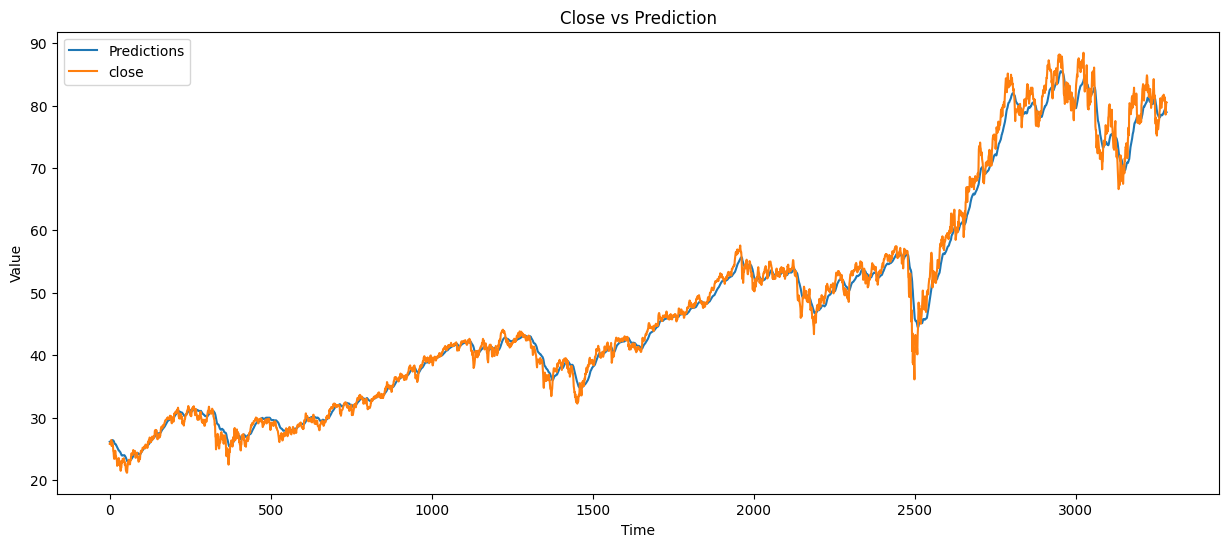

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

prediction = processed_full[processed_full['tic']=='XLB']['prediction'].values
close = processed_full[processed_full['tic']=='XLB']['close'].values

plt.figure(figsize=(15, 6))
plt.plot(prediction, label='Predictions')
# Plot predictions
plt.plot(close, label='close')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Close vs Prediction')
plt.legend()
plt.show()

In [22]:
INDICATORS = INDICATORS + ['prediction']

In [23]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

25965
3582


In [24]:
stock_dimension = len(train.tic.unique()) 
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension #현재 상태를 나타내는 state를 정의. 1+ ticker 개수 x2 + 인디케이터 개수 x ticker개수 
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 9, State Space: 100


In [25]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [26]:
print(buy_cost_list)
num_stock_shares

[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]


[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [27]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

TypeError: ignored

In [28]:
agent = DRLAgent(env = env_train)

if_using_a2c = True ##a2c만 사용해보자
if_using_ddpg = False
if_using_ppo = False
if_using_td3 = False
if_using_sac = False

NameError: ignored